In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import f1_score

In [2]:
import matplotlib.pyplot as plt

def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
data_path = 'data/DRIVE/'

In [147]:
im_list = pd.read_csv(osp.join(data_path, 'test.csv')).vessel_paths.values
mask_list = pd.read_csv(osp.join(data_path, 'test.csv')).mask_paths.values

In [5]:
# im_list = ['../'+n for n in im_list]

In [148]:
im1, im2 = Image.open(im_list[0]), Image.open(im_list[3])
mask1 = Image.open(mask_list[0])

In [149]:
im_list[0], mask_list[0]

('data/DRIVE/manual/01_manual1.gif', 'data/DRIVE/mask/01_mask.gif')

In [8]:
im11 = Image.open('data/DRIVE/2nd_manual/01_manual2.gif')

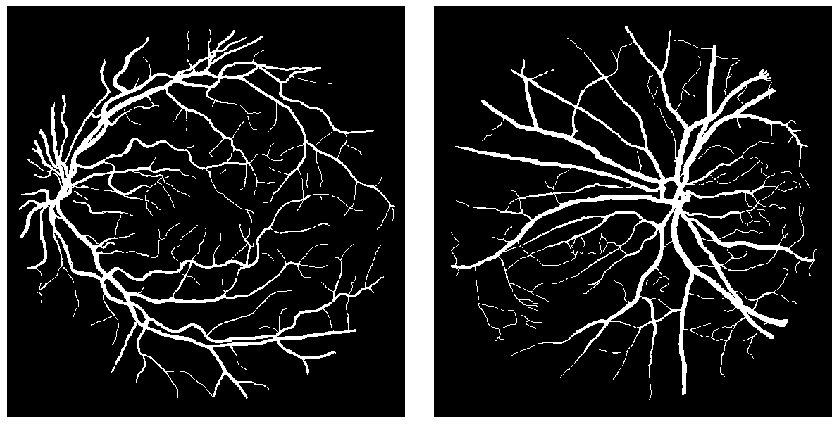

In [9]:
imshow_pair(im1,im2)

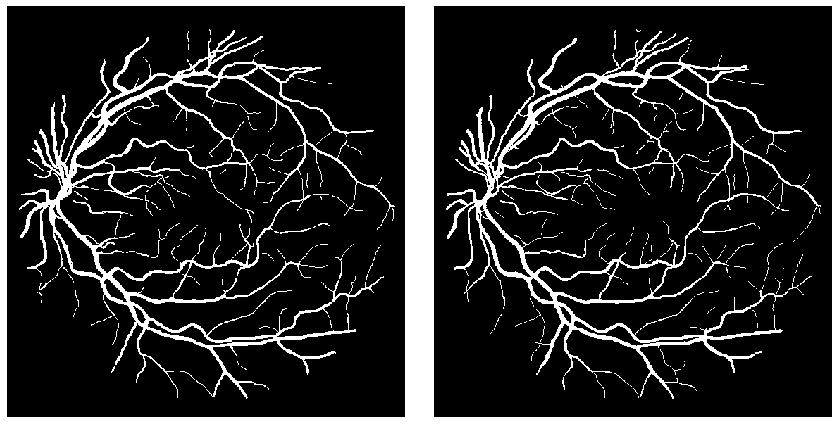

In [10]:
imshow_pair(im1,im11)

In [11]:
def mutual_information(im1, im2):
    # assumes images contain integer values in [0,255]
    X = np.array(im1).astype(float)
    Y = np.array(im2).astype(float)
    hist_2d, _, _ = np.histogram2d(X.ravel(),Y.ravel(),bins=255)
    pxy = hist_2d / float(np.sum(hist_2d)) # joint probability distribution
    
    px = np.sum(pxy, axis=1) # marginal distribution for x over y
    py = np.sum(pxy, axis=0) # marginal distribution for y over x
    
    Hx = - sum(px*np.log(px + (px==0))) # Entropy of X
    Hy = - sum(py*np.log(py + (py==0))) # Entropy of Y
    Hxy = np.sum(-(pxy*np.log(pxy+(pxy==0))).ravel())# Joint Entropy
    
    
    M = Hx+Hy-Hxy # mutual information
    nmi = 2*(M/(Hx+Hy)) # normalized mutual information
    return nmi

In [12]:
# same in sklearn, 4 times slower:
# from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
# normalized_mutual_info_score(np.array(im1).ravel(), np.array(im2).ravel())

In [13]:
mutual_information(im1, im2)

0.001008415336892537

In [14]:
mutual_information(im1,im11)

0.5665034843386163

# Process patches, put them back

In [15]:
import skimage
skimage.__version__

'0.16.2'

In [132]:
from skimage.morphology import binary_erosion, binary_closing, selem
from skimage import img_as_ubyte
from skimage.metrics import structural_similarity as ssim, variation_of_information, mean_squared_error

In [43]:
def erode_patch(patch):
    k = np.random.randint(0, 3) * 2 + 3
    return 255*binary_erosion(patch, selem=selem.rectangle(k, k))

In [44]:
def close_patch(patch):
    k = np.random.randint(0, 3) * 2 + 3
    return 255*binary_closing(patch, selem=selem.rectangle(k, k))

In [45]:
def process_patch(im, xi, yi, patch_size):
    im[yi:yi+patch_size[0], xi:xi+patch_size[1]] = erode_patch(im[yi:yi+patch_size[0], xi:xi+patch_size[1]])
    return im

In [46]:
def degrade_im(im, max_n_patches=20, max_patch_size=(64,64)):
    im = np.array(im)
    h,w = im.shape
    n_patches = np.random.randint(max_n_patches)
    print(n_patches)
    for i in range(n_patches):
        patch_size_h = np.random.randint(3, max_patch_size[0]) # min size of a patch is 3
        patch_size_w = np.random.randint(3, max_patch_size[1])
        
        xi = np.random.randint(0, h - patch_size_h)
        yi = np.random.randint(0, w - patch_size_w)
        
        im = process_patch(im, xi, yi, [patch_size_h, patch_size_w])
    return im

In [184]:
def compute_similarity(im, im_deg, sim_method='mutual_info'):
    im = np.array(im)
    im_deg = np.array(im_deg)
    if sim_method == 'mutual_info':
        return mutual_information(im, im_deg)
    elif sim_method == 'dice':
        return f1_score(im.astype(bool).ravel(), im_deg.astype(bool).ravel())
    elif sim_method == 'ssim':
        return ssim(im.astype(bool), im_deg.astype(bool))
    elif sim_method=='var_info':
        under_seg, over_seg = variation_of_information(im.astype(bool), im_deg.astype(bool))
        return 1-(under_seg + over_seg)
    elif sim_method == 'mse':
        return 1-mean_squared_error(im.astype(bool).ravel(), im_deg.astype(bool).ravel())

6
0.9782588598607731
0.0


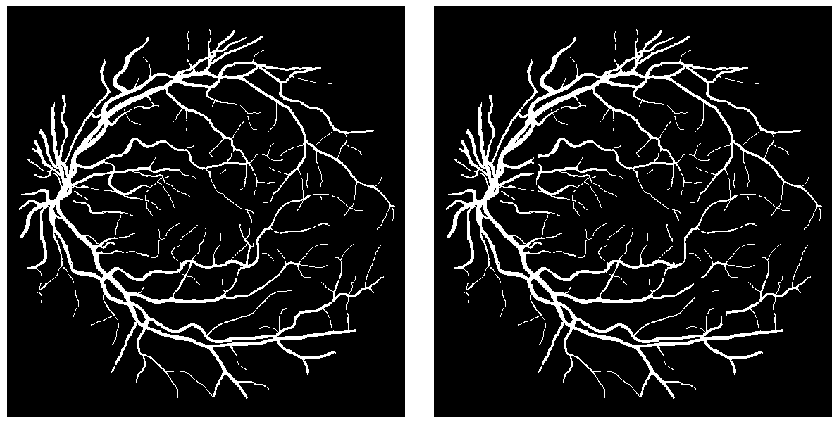

In [185]:
im_deg = degrade_im(im1, max_n_patches=50)
imshow_pair(im1, im_deg)
print(compute_similarity(im1, im_deg, sim_method='mutual_info'))
print(compute_similarity(im1, np.ones_like(im_deg), sim_method='mutual_info'))

## Dataset

In [197]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as tr

from skimage.measure import regionprops

In [229]:
tg_size = 512,512

In [408]:
def degrade_im(im, max_n_patches=20, max_patch_size=(64,64)):
    im = np.array(im)
    h,w = im.shape
    n_patches = np.random.randint(max_n_patches)
    print(n_patches)
    for i in range(n_patches):
        patch_size_h = np.random.randint(3, max_patch_size[0]) # min size of a patch is 3
        patch_size_w = np.random.randint(3, max_patch_size[1])
        
        xi = np.random.randint(0, h - patch_size_h)
        yi = np.random.randint(0, w - patch_size_w)
        
        im = process_patch(im, xi, yi, [patch_size_h, patch_size_w])
    return im

In [298]:
class TrainDataset(Dataset):
    def __init__(self, csv_path, transforms=None, label_values=None):
        df = pd.read_csv(csv_path)
        self.vessels_list = df.vessel_paths
        self.mask_list = df.mask_paths
        self.transforms = transforms

    def crop_to_fov(self, vessels, mask):
        minr, minc, maxr, maxc = regionprops(np.array(mask))[0].bbox
        vessels_crop = Image.fromarray(np.array(vessels)[minr:maxr, minc:maxc])
        return vessels_crop

    def __getitem__(self, index):
        # load image and labels
        vessels = Image.open(self.vessels_list[index]).convert('L')
        mask = Image.open(self.mask_list[index]).convert('L')
        vessels = self.crop_to_fov(vessels, mask)
        if self.transforms is not None:
            vessels = self.transforms(vessels)
            
        vessels_deg = degrade_im(vessels, max_n_patches=50)
        sim = compute_similarity(vessels, vessels_deg, sim_method='mutual_info')

        return tr.ToTensor()(Image.fromarray(vessels_deg)), sim

    def __len__(self):
        return len(self.vessels_list)

In [304]:
path_train_csv = osp.join(data_path, 'train.csv')
path_val_csv = osp.join(data_path, 'val.csv')

train_dataset = TrainDataset(csv_path=path_train_csv)
val_dataset = TrainDataset(csv_path=path_val_csv)
# transforms definition
size = tg_size
# required transforms
resize = tr.Resize(size)
tensorizer = tr.ToTensor()
# geometric transforms
h_flip = tr.RandomHorizontalFlip()
v_flip = tr.RandomVerticalFlip()
rotate = tr.RandomRotation(degrees=45, fill=(0,))
scale = tr.RandomAffine(degrees=0, scale=(0.95, 1.20))
transl = tr.RandomAffine(degrees=0, translate=(0.05, 0))
# either translate, rotate, or scale
scale_transl_rot = tr.RandomChoice([scale, transl, rotate])

train_transforms = tr.Compose([resize,  scale_transl_rot, h_flip, v_flip])
val_transforms = tr.Compose([resize])
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms

In [317]:
im, sim = train_dataset[0]
im2, sim2 = train_dataset[0]

0.9106073367270625 0.9497174423593919


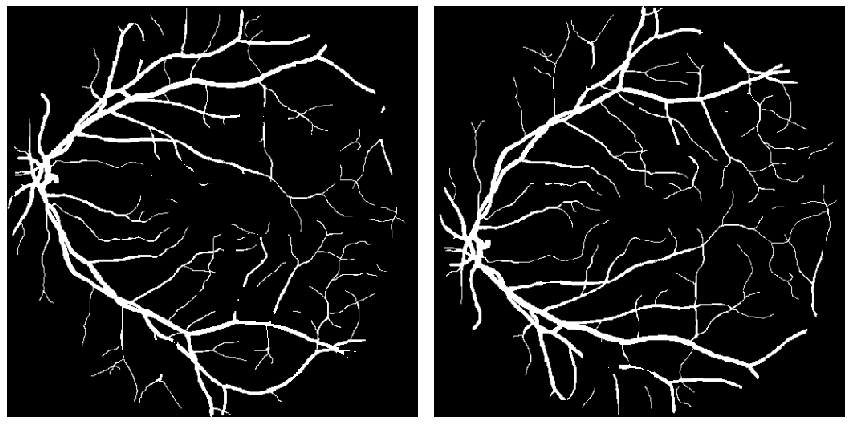

In [318]:
imshow_pair(im.numpy()[0], im2.numpy()[0])
print(sim, sim2)

## Dataset with synthetic examples

In [436]:
from utils import paired_transforms_tv04 as tr

In [437]:
path_train_csv = osp.join(data_path, 'train.csv')
path_val_csv = osp.join(data_path, 'val.csv')

train_dataset = TrainDataset(csv_path=path_train_csv)
val_dataset = TrainDataset(csv_path=path_val_csv)
# transforms definition
size = tg_size
# required transforms
resize = tr.Resize(size)
tensorizer = tr.ToTensor()
# geometric transforms
h_flip = tr.RandomHorizontalFlip()
v_flip = tr.RandomVerticalFlip()
rotate = tr.RandomRotation(degrees=45, fill=(0,))
scale = tr.RandomAffine(degrees=0, scale=(0.95, 1.20))
transl = tr.RandomAffine(degrees=0, translate=(0.05, 0))
# either translate, rotate, or scale
scale_transl_rot = tr.RandomChoice([scale, transl, rotate])

train_transforms = tr.Compose([resize,  scale_transl_rot, h_flip, v_flip])
val_transforms = tr.Compose([resize])
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms

In [477]:
class TrainDataset(Dataset):
    def __init__(self, csv_path, p_manual=0.5, transforms=None):
        df = pd.read_csv(csv_path)
        self.p_manual=0.5
        self.vessels_list = df.vessel_paths
        self.mask_list = df.mask_paths
        self.transforms = transforms

    def crop_to_fov(self, vessels, mask):
        minr, minc, maxr, maxc = regionprops(np.array(mask))[0].bbox
        vessels_crop = Image.fromarray(np.array(vessels)[minr:maxr, minc:maxc])
        return vessels_crop

    def __getitem__(self, index):
        # load image and labels
        vessel_path = self.vessels_list[index]
        vessels_original = Image.open(vessel_path).convert('L')
        mask = Image.open(self.mask_list[index]).convert('L')
        vessels_original = self.crop_to_fov(vessels_original, mask)
  
        if random.random() < self.p_manual:
            epoch=random.choice([20,40,60])
            vessel_path = vessel_path.replace('manual/', 'predicted_epoch_'+str(epoch)+'/')
            print('changing paths to',vessel_path)
            vessels_pred = self.crop_to_fov(Image.open(vessel_path).convert('L'), mask)
            if self.transforms is not None:
                vessels_original, vessels_pred = self.transforms(vessels_original, vessels_pred)
            # thresholding only needed for non-binary images (predictions)
            threshold = 127
            vessels_pred = np.array(vessels_pred)>threshold
            vessels_deg = degrade_im(vessels_pred, max_n_patches=50)
        else:
            vessels_deg = degrade_im(vessels_original, max_n_patches=50)

        sim = compute_similarity(vessels_original, vessels_deg, sim_method='mutual_info')
        return tr.ToTensor()(Image.fromarray(vessels_deg)), sim, tr.ToTensor()(vessels_original)

    def __len__(self):
        return len(self.vessels_list)

In [478]:
train_dataset = TrainDataset(csv_path=path_train_csv)

In [539]:
im, sim, true = train_dataset[0]

28


0.8973317840161812

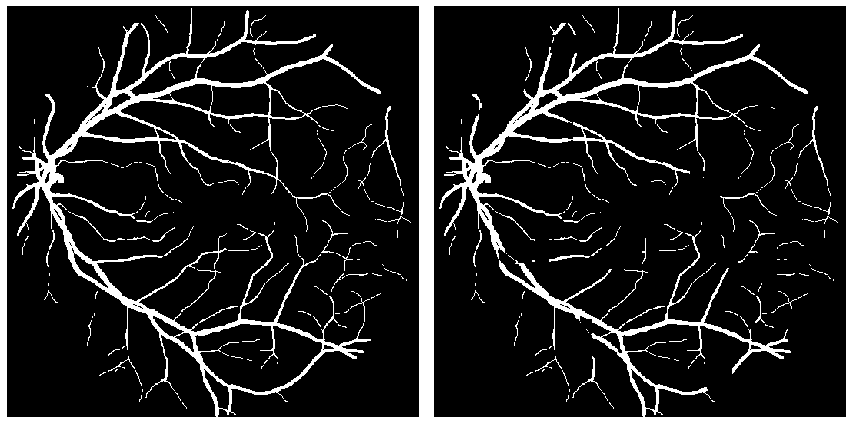

In [540]:
imshow_pair(true.numpy()[0], im.numpy()[0])
sim